# Introduction
This strategy, is a Machine Learning (ML)-driven long/short trading strategy built using Backtrader. It leverages a pre-trained Keras model to predict future price movements (specifically, the likelihood of a long or short opportunity) and then executes trades based on these predictions, incorporating profit targets and stop-loss levels.

Here's a breakdown of its key components:

Machine Learning Model Integration:

The strategy loads a pre-trained Keras model (model_long_short_predict.h5) during its initialization. This model is the core of its decision-making.
In the next method, it prepares input data for the model. This input consists of the current closing price, and a set of Simple Moving Averages (SMAs) and Rates of Change (ROCs) calculated over various time periods.
The SMA values are normalized (scaled between 0 and 1) before being fed into the model, ensuring consistent input ranges. ROC values are used as is.
The pre-trained model then makes a prediction (mY) which typically outputs two values: tLong (the prediction for a long opportunity) and tShort (the prediction for a short opportunity).
Trading Logic based on ML Predictions:

If there is no open position:
* It checks if tLong (the prediction for a long trade) exceeds a configured long_threshold. If true, it places a buy order.
* It checks if tShort (the prediction for a short trade) exceeds a configured short_threshold. If true, it places a sell order.

If a position is open:
* For a long position: It checks if the current closing price (cl) has reached the pre-defined profitTarget or has fallen to the stopTarget. If either condition is met, it closes the position (sells).
* For a short position: It checks if the current closing price (cl) has reached the pre-defined profitTarget (by falling to a certain level) or has risen to the stopTarget. If either condition is met, it closes the position (buys).

Risk Management:

The strategy incorporates built-in risk management with configurable profit_target_pct and stop_target_pct. These percentages are used to calculate the specific limitPrice (for profit taking) and stopPrice (for loss cutting) immediately after an order is placed.
In summary, this strategy uses a deep learning model to generate trading signals (long or short) based on a combination of raw price and calculated technical indicators. It then executes trades based on these signals, always with pre-determined profit targets and stop-loss levels to manage risk.

DISCLAMER: Please remember, this is a demo based on a synthetic data, the actual performance of this algo is immaterial

# Step 1) Data Preparation

In [1]:
%run init_model.py 'algo_ml_long_short_predict'

algo_ml_long_short_predict


In [2]:
# get S3 bucket
s3bucket=!(aws s3 ls | grep algotrading- | awk  '{print $3}')
s3bucket=s3bucket[0]
s3bucket

'algotrading-demo-ver1'

In [3]:
import sys
!{sys.executable} -m pip install PyAthena
!{sys.executable} -m pip install --upgrade numexpr

In [4]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow
import json

role = get_execution_role()
sess = sage.Session()
region = sess.boto_session.region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [5]:
import pandas as pd
from sqlalchemy import create_engine
from pyathena import connect
connection_string = 'awsathena+rest://@'+region+'?s3_staging_dir=s3://'+s3bucket+'/results/'
engine = create_engine(connection_string)
df = pd.read_sql("SELECT dt,open,high,low,close,vol FROM algo_data.hist_data_daily;", engine)
df.set_index(pd.DatetimeIndex(df['dt']),inplace=True)
del df['dt']
df.head()

,open,high,low,close,vol
dt,,,,,
2012-08-13,26.76,26.83,26.41,26.69,23623918.0
2012-08-14,26.80,26.81,26.38,26.48,27477260.0
2012-08-15,26.23,26.47,26.19,26.27,26081909.0
2012-08-16,26.44,26.65,26.34,26.59,25702363.0
2012-08-17,26.57,26.63,26.21,26.33,30379903.0


In [6]:
trainCount=int(len(df)*0.4)
dfTrain = df.iloc[:trainCount]

dfTest = df.iloc[trainCount:]
dfTest.to_csv('local/'+algo_name+'/input/data/training/data_train.csv')
dfTest.head()

,open,high,low,close,vol
dt,,,,,
2014-08-13,33.24,34.15,33.23,34.10,36291008.0
2014-08-14,34.05,34.23,33.74,33.94,25457954.0
2014-08-15,34.10,34.21,33.71,34.17,28582224.0
2014-08-16,34.10,34.21,33.71,34.17,28582224.0
2014-08-17,34.10,34.21,33.71,34.17,28582224.0


<Axes: xlabel='dt'>

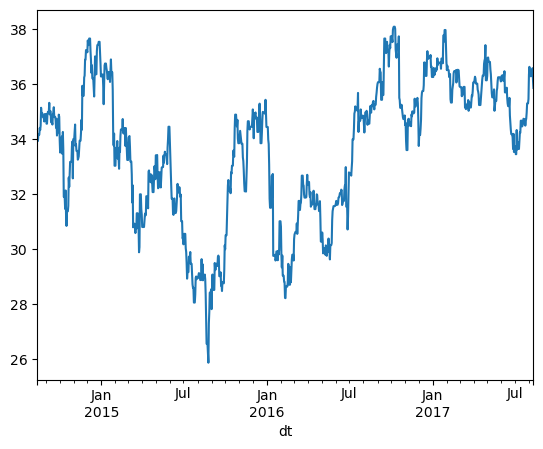

In [7]:
%matplotlib inline
dfTest["close"].plot()

# Step 2) Modify Strategy Configuration 

In the following cell, you can adjust the parameters for the strategy.

* `long_threshold` = Threshold for Long Trade (0 to 1)
* `short_threshold` = Threshold for Short Trade (0 to 1)
* `profit_target_pct` = Profit Target Percentage 
* `stop_target_pct` = Stop Target Percentage
* `size` = The number of shares for a transaction

`Tip`: A good starting point for improving the strategy is modify the profit / stop target and the risk/reward ratio. Another option is to reduce the number of signals by increasing the threshold.

In [8]:
# Here long and short thresholds are 0.5, meaning "I just need to be a bit better than a 50% chance"
%%writefile local/{algo_name}/input/config/hyperparameters.json
{ 
  "long_threshold" : "0.5",
  "short_threshold" : "0.5",
  "profit_target_pct" : "2.00",
  "stop_target_pct" : "1.50",
  "size" : "100"
}

Overwriting local/algo_ml_long_short_predict/input/config/hyperparameters.json


In [9]:
%run update_config.py $algo_name

config={"long_threshold": "0.5", "short_threshold": "0.5", "profit_target_pct": "2.00", "stop_target_pct": "1.50", "size": "100", "algo_name": "algo_ml_long_short_predict", "user": "user", "account": "616431823260", "region": "us-east-1"}


<Figure size 640x480 with 0 Axes>

# Step 3) Modify Strategy Code

In the following cell, you can modify the strategy code. For the first backtests, you can leave it as is.

`Tip`: A good starting point for improving the strategy is to combine the signal from the model with traditional trend indicators (e.g. moving average). This will likely improve the performance. To improve the strategy further, you could increase the accuracy of the machine learning model by including more indicators (e.g. ATR) or modify the input and forecast window. This requires to re-train the machine learning model as this needs to match your strategy. For timeseries forecasting, you could compare the performance with more advanced ML networks (e.g. CNN, LTSM, RNN) and pick the model with the best predictions.

You can also checkout other AWS-provided options for timeseries forecasting and formulate a strategy that uses price predictions and integrate them in your strategy:
* https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html 
* https://aws.amazon.com/forecast/

Here are some helpful links:
* Backtrader Documentation: https://www.backtrader.com/docu/strategy/
* TA-Lib Indicator Reference: https://www.backtrader.com/docu/talibindautoref/
* Backtrader Indicator Reference: https://www.backtrader.com/docu/indautoref/

In [10]:
%%writefile model/{algo_name}.py
import backtrader as bt  # Import the Backtrader framework for backtesting and trading strategies
from algo_base import *
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras  # Import Keras, a high-level API for building and training neural networks (now part of TensorFlow)
from keras import backend as K  # Import Keras backend for low-level operations (often used for clearing session)
from keras.models import load_model  # Import function to load a pre-trained Keras model

class MyStrategy(StrategyTemplate):

    # This method is called once when the strategy is first initialized by Backtrader
    def __init__(self):
        # Call the constructor of the parent class (StrategyTemplate) to ensure its initialization
        super(MyStrategy, self).__init__()

        # --- Load Strategy Configuration Parameters ---
        # These parameters are typically passed into the strategy from an external configuration
        self.config["long_threshold"] = float(self.config["long_threshold"])   # ML prediction confidence needed to go long
        self.config["short_threshold"] = float(self.config["short_threshold"]) # ML prediction confidence needed to go short
        self.config["size"] = int(self.config["size"])                         # Number of shares/units to trade
        self.config["profit_target_pct"] = float(self.config["profit_target_pct"]) # Percentage profit target for exiting a trade
        self.config["stop_target_pct"] = float(self.config["stop_target_pct"])   # Percentage stop-loss target for exiting a trade

        # --- Initialize Internal Strategy Variables ---
        self.order = None      # Stores the current pending/active order (e.g., buy, sell)
        self.orderPlaced = False # Flag to track if an order has been recently placed (not explicitly used here but common)

        # --- Load the Pre-trained Machine Learning Model ---
        # This loads the neural network 'brain' that will provide buy/sell signals
        self.model = load_model('model_long_short_predict.h5')

        # --- Configuration for Technical Indicators ---
        self.repeatCount = 15  # Number of different periods for SMA and ROC calculations
        self.repeatStep = 1    # Step size for increasing the periods

        # --- Calculate Absolute Profit/Stop-Loss Targets from Percentages ---
        # Convert percentage targets to decimal values for calculation
        self.profitTarget = self.config["profit_target_pct"] / 100.0
        self.stopTarget = self.config["stop_target_pct"] / 100.0
        self.size = self.config["size"] # Store the trade size

        # --- Initialize Lists for Technical Indicators ---
        self.sma = []  # List to hold Backtrader's SMA indicator lines
        self.roc = []  # List to hold Backtrader's ROC indicator lines

        # --- Prepare Header for Data (if needed for debugging/export, though not used for model input directly) ---
        self.hData = ["dt"]
        self.hData.append("close")

        # --- Create SMA (Simple Moving Average) Indicators ---
        # Loop to create 'repeatCount' different SMA indicators, each with a different timeperiod
        for a in range(0, self.repeatCount):
            tp = (a + 1) * self.repeatStep + 1  # Calculate the time period for the current SMA (e.g., 2, 3, ..., 16)
            self.hData.append("sma" + str(tp))  # Add SMA column name to header
            # Add SMA indicator to the strategy, linked to the main data feed
            # plot=False prevents it from being plotted by default in Backtrader charts
            self.sma.append(bt.talib.SMA(self.data, timeperiod=tp, plot=False))

        # --- Create ROC (Rate of Change) Indicators ---
        # Loop to create 'repeatCount' different ROC indicators, each with a different timeperiod
        for a in range(0, self.repeatCount):
            tp = (a + 1) * self.repeatStep + 1  # Calculate the time period for the current ROC
            self.hData.append("roc" + str(tp))  # Add ROC column name to header
            # Add ROC indicator to the strategy, linked to the main data feed
            self.roc.append(bt.talib.ROC(self.data, timeperiod=tp, plot=False))

    # --- Static Method: Initializes the Trading Broker (Simulated Account) ---
    # This function is called by Cerebro to set up the trading environment
    def init_broker(broker):
        broker.setcash(100000.0)      # Set the initial cash in the simulated trading account
        broker.setcommission(commission=0.0) # Set trading commission to 0 (for simplicity/testing)

    # --- Static Method: Adds Market Data to Cerebro ---
    # This function defines how the historical market data is loaded
    def add_data(cerebro):
        data = btfeeds.GenericCSVData( # Use GenericCSVData to read data from a CSV file
            dataname=MyStrategy.TRAIN_FILE, # Path to the CSV file (TRAIN_FILE is likely defined elsewhere)
            dtformat=('%Y-%m-%d'),      # Date format in the CSV
            timeframe=bt.TimeFrame.Days, # Data is daily
            datetime=0,                 # Date column index in CSV (0-based)
            time=-1,                    # Time column index (not present, or not used here)
            high=2,                     # High price column index
            low=3,                      # Low price column index
            open=1,                     # Open price column index
            close=4,                    # Close price column index
            volume=5,                   # Volume column index
            openinterest=-1             # Open Interest column index (not present, or not used here)
        )
        cerebro.adddata(data) # Add the configured data feed to the Cerebro engine

    # --- Main Strategy Logic: Executed on Each New Data Bar (e.g., each day) ---
    def next(self):
        super(MyStrategy, self).next() # Call the parent class's next method

        # --- Get Current Market Data ---
        dt = self.datas[0].datetime.datetime(0) # Get the current date/time from the primary data feed
        cl = self.dataclose[0]                 # Get the current day's closing price

        # --- Prepare Input for the Machine Learning Model ---
        inputRec = [] # List to store the final input features for the ML model

        # Temporary list to hold close and SMA values for normalization
        inputRec0 = []
        inputRec0.append(cl) # Add current closing price

        # Collect SMA values, handling NaN (Not a Number) by using current close price
        for a in range(0, self.repeatCount):
            if math.isnan(self.sma[a][0]): # Check if the SMA value is NaN (means not enough data yet)
                inputRec0.append(cl)       # If NaN, use current close price as a fallback
            else:
                inputRec0.append(self.sma[a][0]) # Otherwise, use the calculated SMA value

        # --- Min-Max Normalization for Close and SMA Values ---
        # Scale values to a range between 0 and 1, as the ML model expects normalized inputs
        m1 = min(inputRec0) # Find the minimum value among current close and SMAs
        m2 = max(inputRec0) # Find the maximum value
        for a in inputRec0:
            if m2 - m1 == 0: # Avoid division by zero if all values are the same
                inputRec.append(0)
            else:
                inputRec.append((a - m1) / (m2 - m1)) # Apply min-max normalization formula

        # Collect ROC values, handling NaN by using 0
        for a in range(0, self.repeatCount):
            if math.isnan(self.roc[a][0]): # Check if the ROC value is NaN
                inputRec.append(0)         # If NaN, use 0 as a fallback
            else:
                inputRec.append(self.roc[a][0]) # Otherwise, use the calculated ROC value

        # Initialize mX and dataX (these lines appear redundant or misplaced, as mX is re-initialized below)
        mX = []
        dataX = np.array(mX)

        # --- ML Prediction Section ---
        mX = []
        mX.append(np.array(inputRec)) # Add the prepared input features as a single sample
        # Ensure the input array for the model is at least 2-dimensional (even for a single sample)
        dataX = np.atleast_2d(np.array(mX))

        mY = self.model.predict(dataX) # Get the prediction from the loaded ML model
        mY_squeezed = np.squeeze(mY)   # Remove single-dimensional entries from the shape of the array
                                       # mY will be like [[val1, val2]], squeezed to [val1, val2]

        tLong = mY_squeezed[0]  # The first prediction value (e.g., probability of a 'long' signal)
        tShort = mY_squeezed[1] # The second prediction value (e.g., probability of a 'short' signal)

        # --- Trading Logic: Enter Trades Based on ML Prediction ---
        if not self.position: # Check if there is no open position (we are 'flat')
            # Determine if the ML 'long' prediction confidence is above the configured threshold
            fLong = (tLong > self.config["long_threshold"])
            # Determine if the ML 'short' prediction confidence is above the configured threshold
            fShort = (tShort > self.config["short_threshold"])

            if fLong: # If the 'long' signal is strong enough
                self.order = self.buy(size=self.size) # Place a buy order (go long)
                # Set dynamic profit target and stop-loss prices based on current close
                self.limitPrice = cl + self.profitTarget * cl # Price to sell for profit
                self.stopPrice = cl - self.stopTarget * cl   # Price to sell to cut losses
            elif fShort: # Else if the 'short' signal is strong enough
                self.order = self.sell(size=self.size) # Place a sell order (go short)
                # Set dynamic profit target and stop-loss prices for a short position
                self.limitPrice = cl - self.profitTarget * cl # Price to buy back for profit
                self.stopPrice = cl + self.stopTarget * cl   # Price to buy back to cut losses

        # --- Trading Logic: Manage and Exit Existing Trades ---
        if self.position: # If there is an open position
            if self.position.size > 0: # If currently LONG (positive position size)
                # Check if current price hits profit target or stop-loss
                if cl >= self.limitPrice or cl <= self.stopPrice:
                    self.order = self.sell(size=self.size) # Sell to close the long position
            elif self.position.size < 0: # If currently SHORT (negative position size)
                # Check if current price hits profit target or stop-loss for short
                if cl <= self.limitPrice or cl >= self.stopPrice:
                    self.order = self.buy(size=self.size) # Buy to cover the short position

Overwriting model/algo_ml_long_short_predict.py


# Step 4) Backtest Locally

In this phase we create a container, which consists of the execution environment (defined in the Dockerfile), maps the local storage which contains data and hyperparameters, and uses functionality from the backtesting library to calculate the performance of the strategy - win/loss streak. drawdown, PnL, etc.  
Please note that the initial docker build may take a few minutes. Subsequent runs are fast

In [11]:
#Build Local Algo Image
!docker build -t $algo_name .
!docker run -v $(pwd)/local/$algo_name:/opt/ml --rm $algo_name train

[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (2/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.08kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.19.0    0.1s
[+] Building 0.3s (22/23)                                        docker:default
 => [internal] load build context                                          0.0s
 => => transferring context: 11.39kB                                       0.0s
 => [ 1/18] FROM docker.io/tensorflow/tensorflow:2.19.0@sha256:f24e8494d4  0.0s
 => CACHED [ 2/18] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/18] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/18] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/18] RUN pip install numpy

[+] Building 0.9s (18/24)                                        docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy

[+] Building 1.5s (18/24)                                        docker:default
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask

[+] Building 2.0s (18/24)                                        docker:default
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask

[+] Building 2.5s (19/24)                                        docker:default
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-li

[+] Building 3.1s (19/24)                                        docker:default
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-li

[+] Building 3.5s (19/24)                                        docker:default
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install panda

[+] Building 4.0s (20/24)                                        docker:default
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy

[+] Building 4.6s (20/24)                                        docker:default
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy

[+] Building 5.2s (20/24)                                        docker:default
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy

[+] Building 5.8s (20/24)                                        docker:default
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ign

[+] Building 6.4s (20/24)                                        docker:default
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunic

[+] Building 6.9s (20/24)                                        docker:default
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunic

[+] Building 7.5s (20/24)                                        docker:default
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunic

[+] Building 8.0s (20/24)                                        docker:default
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunic

[+] Building 8.5s (21/24)                                        docker:default
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install sciki

[+] Building 9.1s (21/24)                                        docker:default
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install sciki

[+] Building 9.7s (21/24)                                        docker:default
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install sciki

[+] Building 10.3s (21/24)                                       docker:default
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install sciki

[+] Building 10.7s (21/24)                                       docker:default
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ign

[+] Building 11.3s (21/24)                                       docker:default
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ign

[+] Building 11.9s (21/24)                                       docker:default
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ign

[+] Building 12.4s (21/24)                                       docker:default
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunic

[+] Building 12.9s (21/24)                                       docker:default
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunicorn                                0.0s
 => CACHED [14/20] RUN pip install tenso

[+] Building 13.4s (21/24)                                       docker:default
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunicorn                                0.0s
 => CACHED [14/20] RUN pip install tenso

[+] Building 14.0s (21/24)                                       docker:default
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install gevent                                  0.0s
 => CACHED [13/20] RUN pip install gunicorn                                0.0s
 => CACHED [14/20] RUN pip install tenso

[+] Building 14.6s (24/25)                                       docker:default
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy                                   0.0s
 => CACHED [ 6/20] RUN pip install ta-lib                                  0.0s
 => CACHED [ 7/20] RUN pip install scipy                                   0.0s
 => CACHED [ 8/20] RUN pip install scikit-learn                            0.0s
 => CACHED [ 9/20] RUN pip install pandas                                  0.0s
 => CACHED [10/20] RUN pip install --ignore-installed blinker              0.0s
 => CACHED [11/20] RUN pip install flask                                   0.0s
 => CACHED [12/20] RUN pip install geven

[+] Building 15.0s (25/25) FINISHED                              docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.34kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.1.0rc2  0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 567B                                          0.0s
 => [ 1/20] FROM docker.io/tensorflow/tensorflow:2.1.0rc2-py3@sha256:655c  0.0s
 => CACHED [ 2/20] RUN apt-get -y update &&          apt-get install -y -  0.0s
 => CACHED [ 3/20] RUN wget  https://github.com/ta-lib/ta-lib/releases/do  0.0s
 => CACHED [ 4/20] RUN python3 -m pip install --upgrade pip                0.0s
 => CACHED [ 5/20] RUN pip install numpy

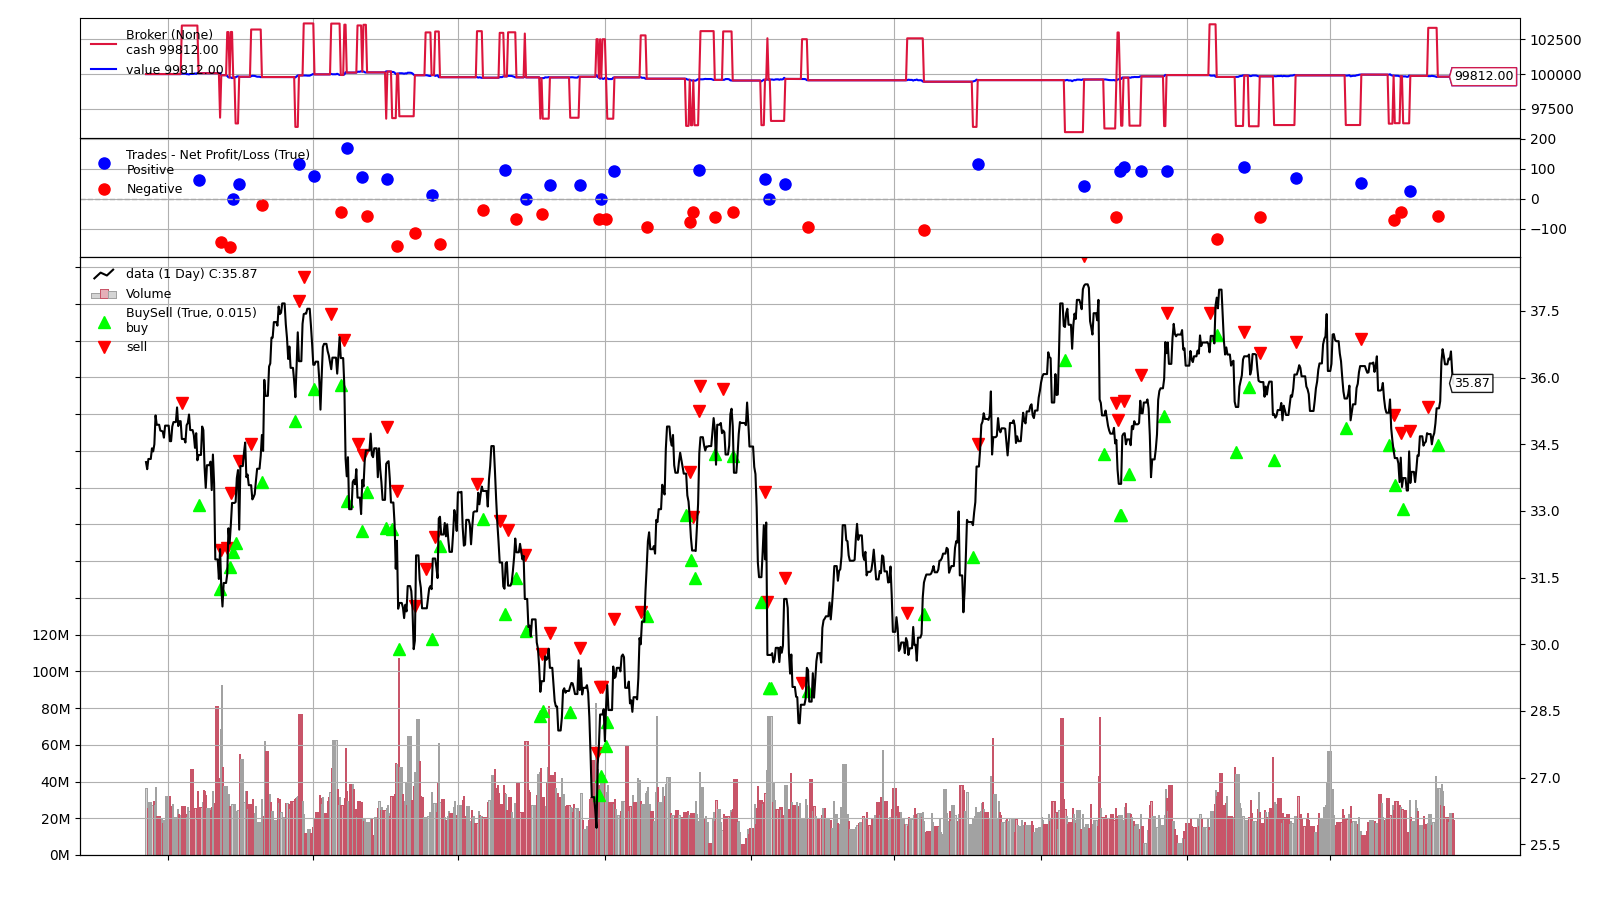

In [12]:
from IPython.display import Image
Image(filename='local/'+algo_name+'/model/chart.png')

## Refine your trading strategy (step 2 to 4). Once you are ready, move on to the next step.

# Step 5) Backtest on SageMaker and submit performance

Here we do the same backtesting, which was done localy in the previous step, just on the cluster. We push the local image to the container registry, then spin a Sagemaker cluster (you can define the number of instances in its config). This is serverless - i.e. AWS will take care of provisioning the compute resources

In [13]:
#Deploy Algo Image to ECS
!./build_and_push.sh $algo_name

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (3/3)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.08kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:2.19.0    0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
[+] Building 0.2s (23/23) FINISHED                               docker:default
 => [internal] load build definition from Doc

In [14]:
#Run Remote Forwardtest via SageMaker
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator 

role = get_execution_role()
sess = sage.Session()

WORK_DIRECTORY = 'local/'+algo_name+'/input/data/training'
data_location = sess.upload_data(WORK_DIRECTORY, key_prefix='data')
print(data_location)

conf_file='local/'+algo_name+'/input/config/hyperparameters.json'
with open(conf_file, 'r') as f:
    config = json.load(f)
print(config)

prefix=algo_name
job_name=prefix.replace('_','-')

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = f'{account}.dkr.ecr.{region}.amazonaws.com/{prefix}:latest'

algo = sage.estimator.Estimator(
    image_uri=image,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path="s3://{}/output".format(sess.default_bucket()),
    sagemaker_session=sess,
    base_job_name=job_name,
    hyperparameters=config,
    metric_definitions=[
        {
            "Name": "algo:pnl",
            "Regex": "Total PnL:(.*?)]"
        },
        {
            "Name": "algo:sharpe_ratio",
            "Regex": "Sharpe Ratio:(.*?),"
        }
    ])
algo.fit(data_location)

INFO:sagemaker:Creating training-job with name: algo-ml-long-short-predict-2025-06-25-23-06-34-802


s3://sagemaker-us-east-1-616431823260/data
{'long_threshold': '0.5', 'short_threshold': '0.5', 'profit_target_pct': '2.00', 'stop_target_pct': '1.50', 'size': '100', 'algo_name': 'algo_ml_long_short_predict', 'user': 'user', 'account': '616431823260', 'region': 'us-east-1'}
2025-06-25 23:06:36 Starting - Starting the training job...
2025-06-25 23:07:01 Starting - Preparing the instances for training...
2025-06-25 23:07:30 Downloading - Downloading input data...
2025-06-25 23:07:55 Downloading - Downloading the training image...
2025-06-25 23:08:36 Training - Training image download completed. Training in progress...import:algo_ml_long_short_predict
2025-06-25 23:08:47.785417: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
<class 'algo_ml_long_short_pred

In [15]:
#Get Algo Metrics
from sagemaker.analytics import TrainingJobAnalytics

latest_job_name = algo.latest_training_job.job_name
metrics_dataframe = TrainingJobAnalytics(training_job_name=latest_job_name).dataframe()
metrics_dataframe

,timestamp,metric_name,value
0,0.0,algo:pnl,-188.00
1,0.0,algo:sharpe_ratio,-3.36


tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'


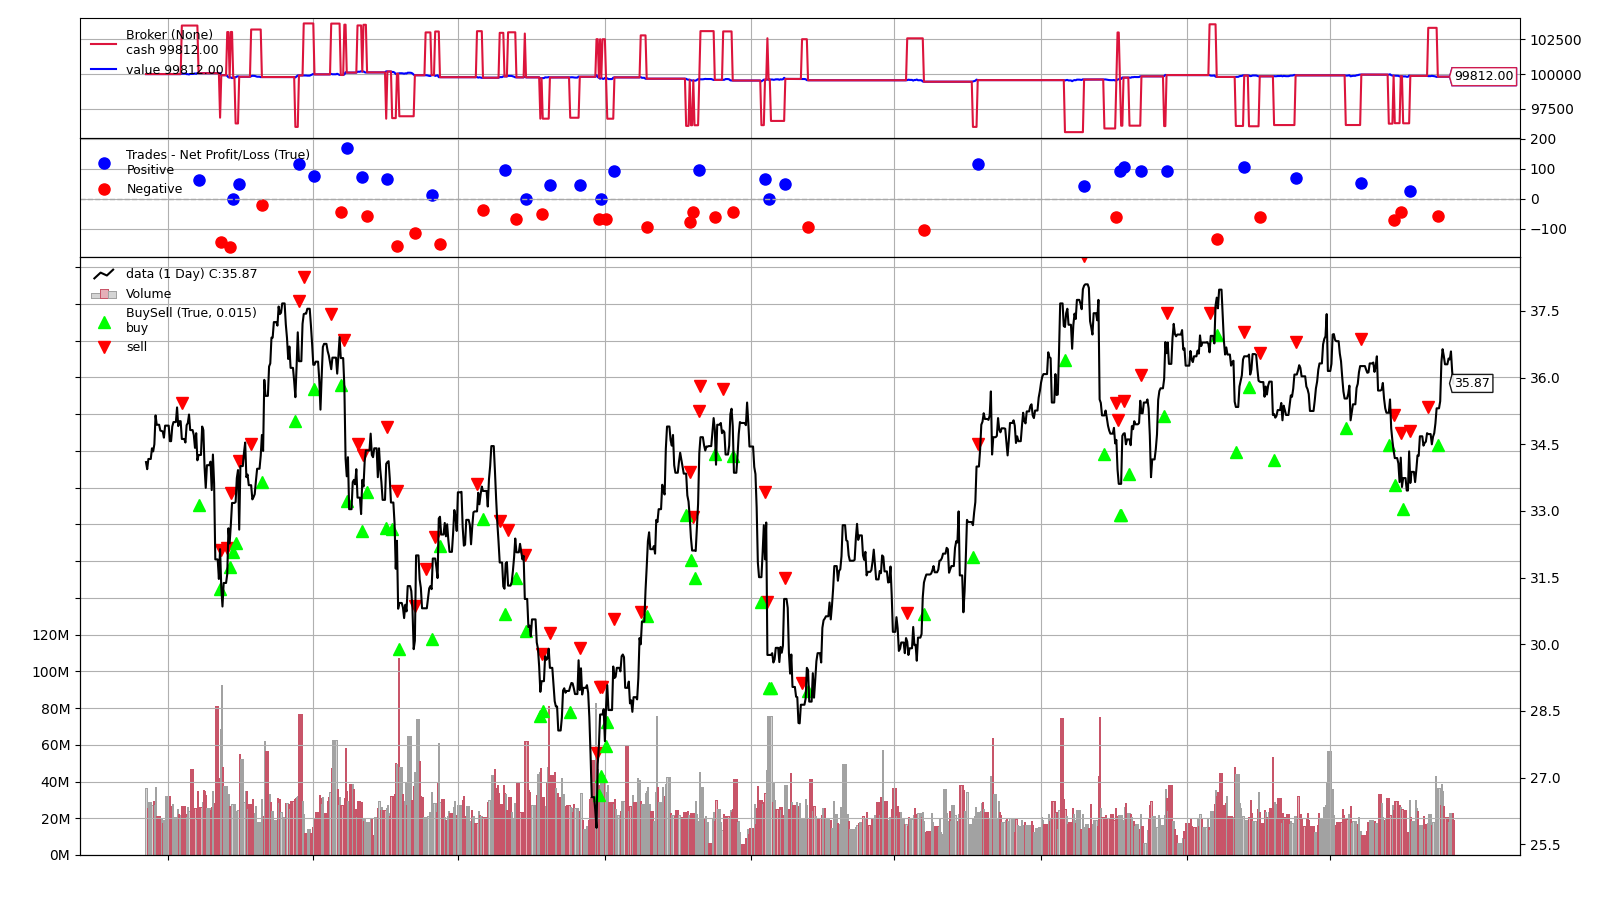

In [16]:
#Get Algo Chart from S3
model_name=algo.model_data.replace('s3://'+sess.default_bucket()+'/','')
import boto3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())
my_bucket.download_file(model_name,'model.tar.gz')
!tar -xzf model.tar.gz
!rm model.tar.gz
from IPython.display import Image
Image(filename='chart.png') 